# **Tutorial 2 - Image classification using SIFT and SVM**

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## 1. Prepare the dataset

In this tutorial, we will use the MNIST dataset. It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

In [ ]:
mnist = fetch_openml('mnist_784')
mnist.data

/home/htrvu/anaconda3/envs/htrvu/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
all_images = mnist.data.to_numpy().reshape(-1, 28, 28).astype(np.uint8)
all_labels = mnist.target.to_numpy().astype(np.uint8)

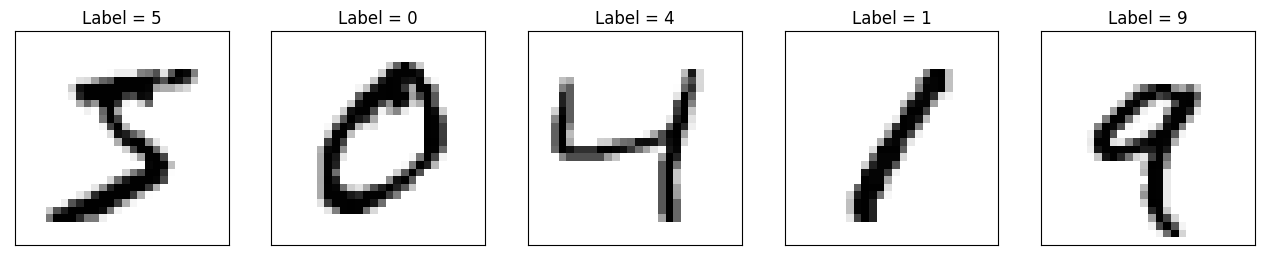

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.imshow(all_images[i], cmap=plt.cm.gray_r, interpolation='nearest')
  plt.title('Label = ' + str(all_labels[i]))
  plt.xticks([])
  plt.yticks([])

We will use 60000 images for training, the rest is for testing.


In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=1./7., random_state=42)


In [ ]:
print('Train images:', train_images.shape)
print('Train labels:', train_labels.shape)
print('Test images:', test_images.shape)
print('Test labels:', test_labels.shape)

Train images: (60000, 28, 28)
Train labels: (60000,)
Test images: (10000, 28, 28)
Test labels: (10000,)


## 2. Step by step

### 2.1. Extract Features with SIFT

SIFT is an algorithm in computer vision to detect and describe local features in images. This is an example for the result of SIFT on images of MNIST dataset:

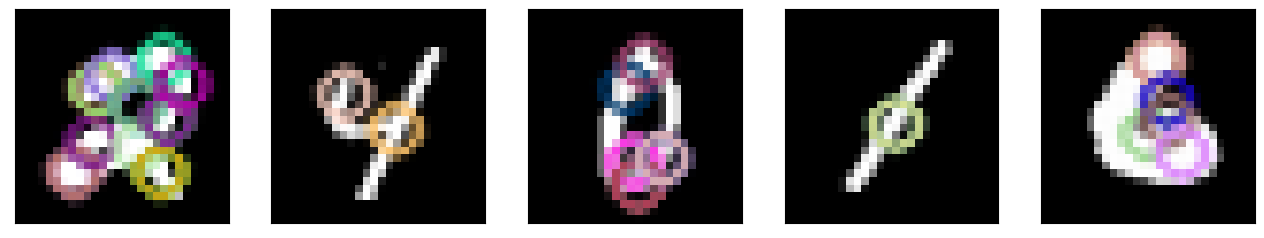

In [ ]:
sift = cv2.SIFT_create()
plt.figure(figsize=(16, 10))
for i in range(5):
  ex_image = train_images[i].copy()
  kp, des = sift.detectAndCompute(ex_image, None)
  res_image = cv2.drawKeypoints(ex_image, kp, ex_image)
  plt.subplot(1, 5, i + 1)
  plt.imshow(res_image)
  plt.xticks([])
  plt.yticks([])

 We will run this algorithm for every class in MNIST dataset (from 0 to 9). 

In [ ]:
def get_images_dict(images, labels):
  d = {}
  for i in range(len(labels)):
    if labels[i] not in d:
      d[labels[i]] = []
    d[labels[i]].append(images[i])
  return d

In [ ]:
def sift_features(images_dict):
  sift_vectors = {}
  descriptor_list = []
  sift = cv2.SIFT_create()
  for label, images in images_dict.items():
    features = []
    for image in images:
      kp, des = sift.detectAndCompute(image, None)
      if des is not None:
        descriptor_list.extend(des)
        features.append(des)
    sift_vectors[label] = features
  return [descriptor_list, sift_vectors]

In [ ]:
train_dict = get_images_dict(train_images, train_labels)
train_sifts = sift_features(train_dict)
train_descriptor_list = train_sifts[0]
train_bovw_feature = train_sifts[1]

In [ ]:
test_dict = get_images_dict(test_images, test_labels)
test_bovw_feature = sift_features(test_dict)[1]

For a better understanding about the above steps:
- `train_descriptor_list` contains the description of every key points of ALL training images (no matter which image each key point belongs to). So its shape will looks like `(N, 128)`
- `train_bovw_feature` contains the description of every key points of each image, in each class. It will looks like
    ```bash
    0: [(N_1, 128), (N_2, 128), ...],
    1: [(N_3, 128), (N_4, 128), ...],
    ...
    ```

In [ ]:
print(train_descriptor_list[0].shape)
print(train_bovw_feature[0][0].shape)

(128,)
(8, 128)


### 2.2. Learn Visual Vocabulary with KMeans

From the above `train_descriptor_list`, we run KMeans algorithm to quantize the feature space. After getting `k` centers, we will create a histogram vector with `k` dimensions for every image, by asigning each descriptor of its key points to the corresponding cluster's center.

In [ ]:
def run_kmeans(k, descriptor_list):
  kmeans = KMeans(n_clusters=k, n_init=10)
  kmeans.fit(descriptor_list)
  visual_words = kmeans.cluster_centers_
  return visual_words, kmeans

In [ ]:
def gen_histograms(bovw_feature, centers, model):
  features_dict = {}
  for label, image_descriptors in bovw_feature.items():
    features = []
    for descriptors in image_descriptors:
      histogram = np.zeros(len(centers))
      for desc in descriptors:
        idx = model.predict([desc])[0]
        histogram[idx] += 1
      features.append(histogram)
    features_dict[label] = features
  return features_dict

In [ ]:
visual_words, kmeans = run_kmeans(128, train_descriptor_list)

In [ ]:
train_bovw = gen_histograms(train_bovw_feature, visual_words, kmeans)
test_bovw = gen_histograms(test_bovw_feature, visual_words, kmeans)

### 2.3. Classify with SVM

For convenience, we will use class `sklearn.svm.SVC` of Sklearn library.

**Note**. In this tutorial, we just try different kernel for SVM for demo purpose. You could play around with other parameters like regularization `C`, kernel coefficient `gamma`,... for better results.

In [ ]:
def bovw_to_dataset(bovw):
  X, y = [], []
  for label, features_list in bovw.items():
    for features in features_list:
      features = features / np.linalg.norm(features)
      X.append(features)
      y.append(label)
  X = normalize(np.asarray(X))
  y = np.asarray(y)
  return X, y

def run_svm(train_bovw, test_bovw, kernel='linear'):
  X_train, y_train = bovw_to_dataset(train_bovw)
  X_test, y_test = bovw_to_dataset(test_bovw)
  model = SVC(kernel=kernel)
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [ ]:
run_svm(train_bovw, test_bovw, 'linear')

0.7757085848767011

## 3. Experiments

We will run this approach with different values of parameter `n_clusters` (for KMeans) and `kernel` (for SVM).

In [ ]:
def experiments(n_clusters, kernel='linear'):
  print(f'Running with n_cluster = {n_clusters}, kernel = {kernel}...')
  visual_words, kmeans = run_kmeans(n_clusters, train_descriptor_list)
  train_bovw = gen_histograms(train_bovw_feature, visual_words, kmeans)
  test_bovw = gen_histograms(test_bovw_feature, visual_words, kmeans)
  accuracy = run_svm(train_bovw, test_bovw, kernel)
  return accuracy

In [ ]:
def bar_plot(data, title, xlabel):
  params = list(data.keys())
  accs = list(data.values())
  idx = np.arange(len(params))
    
  fig = plt.figure(figsize = (8, 5))
  plt.xlabel(xlabel)
  plt.ylabel("Accuracy")
  plt.xticks(idx, params)
  plt.title(title)
  bars = plt.bar(idx, accs, width=0.5)
  plt.bar_label(bars)
  plt.show()

### 3.1. SVM with kernel = linear

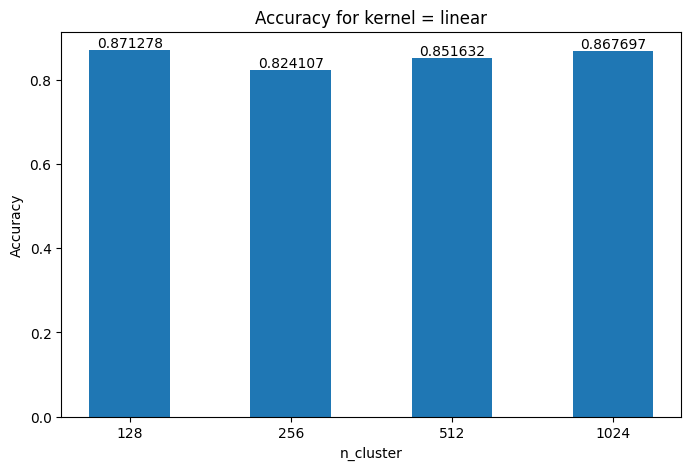

In [ ]:
acc1 = experiments(128, 'linear')
acc2 = experiments(256, 'linear')
acc3 = experiments(512, 'linear')
acc4 = experiments(1024, 'linear')
bar_plot({
    128: acc1,
    256: acc2,
    512: acc3,
    1024: acc4
}, "Accuracy for kernel = linear", "n_cluster")

### 3.2. KMeans with n_cluster=1024

Running with n_cluster = 1024, kernel = linear...
Running with n_cluster = 1024, kernel = poly...
Running with n_cluster = 1024, kernel = rbf...
Running with n_cluster = 1024, kernel = sigmoid...


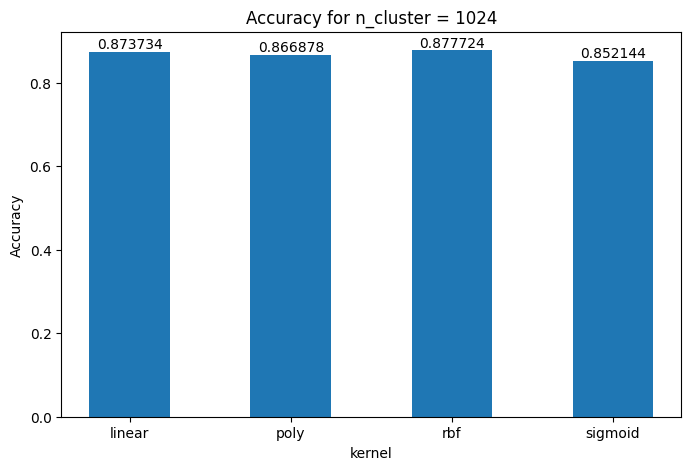

In [ ]:
acc1 = experiments(1024, 'linear')
acc2 = experiments(1024, 'poly')
acc3 = experiments(1024, 'rbf')
acc4 = experiments(1024, 'sigmoid')
bar_plot({
    'linear': acc1,
    'poly': acc2,
    'rbf': acc3,
    'sigmoid': acc4
}, "Accuracy for n_cluster = 1024", "kernel")